In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
# takes list of images as input
# returns array of sift descriptors as ddescribed in task 
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
# take features from function above
# return vocabulary
def cluster_features(features, k=200):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

In [3]:
#input clusters and data that is just and array of images
def bag_of_words(clusters, data, idf=True):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        #print(des)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
    
    if idf:
        bags_array = np.array(all_bags)
        bags_array[bags_array != 0] = 1
        
        idf_w = np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))
        #print(np.min(np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))))
        #print(all_bags[0])
        all_bags = [(bag/bag.shape[0]) * idf_w for bag in all_bags]        
        #print(all_bags[0])
            
        
    return all_bags

#bags = bag_of_words(clusters, train)

In [5]:
'''
    Gennemløb alle kategorier
    For hver kategori
        skaf alle billeder og split dem i train og test set
        for hvert billede i directory
'''

# Importing packages
import pandas as pd
from sklearn.model_selection import train_test_split

# List of tables
category_tables = []

# Function for generating table
def gen_table(path):
    # Current table
    this_table = {
        "file_name":[],
        "category":[],
        "train-test":[],
        "im":[],
        "hist":[],
    }

    # Retrieve images
    images = os.listdir(path)
    #print(images)

    # Train-test division
    train, test = train_test_split(images, test_size=0.5, random_state=42)
    conv_train = [cv2.imread(os.path.join(path, file)) for file in train]
    conv_test = [cv2.imread(os.path.join(path, file)) for file in test]

    for file in os.listdir(path):
        # File name
        this_table["file_name"] = this_table.get("file_name", []) + [file]
        # Category
        this_table["category"] = this_table.get("category", []) + [path.split("/")[-1]]
        # Image
        im = cv2.imread(os.path.join(path, file))
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        this_table["im"] = this_table.get("im", []) + [im_gray]
        # train or test
        train_test = "train" if file in train else "test"
        this_table["train-test"] = this_table.get("train-test", []) + [train_test]
    
    features = extract_features(conv_train)
    clusters = cluster_features(features, k=300)
    this_table["hist"] = bag_of_words(clusters, this_table["im"], idf=True)


    category_tables.append(this_table)

# Categories and categories paths
category_limit = 5
category_path = "caltech-101/101_ObjectCategories"
categories = os.listdir(f"{category_path}/")[:category_limit]
category_dir_list = [os.path.join(category_path, category) for category in categories]

# Looping category_dir_list + generating table
for category_dir in category_dir_list:
    gen_table(category_dir)


In [6]:
df_list = [pd.DataFrame(table) for table in category_tables]
merged_tables = pd.concat(df_list)
merged_tables = merged_tables.reset_index()

#tb = pd.DataFrame(category_tables[1])
# tb

In [7]:
def common_words(hist1, hist2):
    min = np.minimum(hist1, hist2)
    return -np.sum(min)

def euclidian(hist1, hist2):
    # hist1 = hist1 / np.linalg.norm(hist1)
    # hist2 = hist2 / np.linalg.norm(hist2)

    return np.linalg.norm(hist1 - hist2)

def bhattacharyya(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)
    
    return np.sum((hist1*hist2)**.5)

def retrieve(df,  measure, retrieve=0):
    retrieval_img = df.iloc[retrieve]
    print(retrieval_img)
    
    distances = []
    for index, row in df.iterrows():
        dist = measure(retrieval_img.loc["hist"], row.loc["hist"])
        distances.append((dist, index))
    
    distances = sorted(distances, key = lambda x:x[0])
    print(distances)
    
    indexes = [dist[1] for dist in distances]
    print(indexes)
    
    #return merged_tables.iloc[indexes]
    return merged_tables.iloc[indexes]
    

#results = retrieve(merged_tables, measure=euclidian, retrieve=0)
results = retrieve(merged_tables, measure=euclidian, retrieve=0)
results

index                                                         0
file_name                                        image_0032.jpg
category                                                gerenuk
train-test                                                 test
im            [[171, 171, 171, 171, 171, 171, 171, 171, 172,...
hist          [0.0, 0.015576577631131516, 0.0077882888155657...
Name: 0, dtype: object
[(0.0, 0), (0.3171333078286292, 18), (0.3232947493834196, 12), (0.3434009789680899, 13), (0.34678854128985387, 16), (0.3656821153519759, 27), (0.3702620803391707, 11), (0.3717394207517689, 162), (0.3729396546757102, 29), (0.37609614966512617, 63), (0.37767371180788845, 3), (0.3783452792718924, 2), (0.37965327218658385, 95), (0.379816594767013, 34), (0.38437184938962243, 123), (0.386430614772286, 81), (0.3881193047520287, 91), (0.3885536818569415, 50), (0.38911351892589413, 128), (0.389655420860189, 40), (0.39041073739914606, 67), (0.39049974181289404, 299), (0.39090221434287925, 122), (

,index,file_name,category,train-test,im,hist
0,0,image_0032.jpg,gerenuk,test,"[[171, 171, 171, 171, 171, 171, 171, 171, 172,...","[0.0, 0.015576577631131516, 0.0077882888155657..."
18,18,image_0007.jpg,gerenuk,train,"[[47, 44, 56, 43, 34, 49, 48, 45, 62, 86, 95, ...","[0.032105941448691624, 0.0, 0.0, 0.01535056728..."
12,12,image_0008.jpg,gerenuk,test,"[[85, 36, 34, 105, 125, 136, 86, 105, 85, 143,...","[0.016052970724345812, 0.0, 0.0311531552622630..."
13,13,image_0009.jpg,gerenuk,test,"[[49, 66, 66, 152, 144, 139, 120, 106, 42, 47,...","[0.008026485362172906, 0.0, 0.0311531552622630..."
16,16,image_0022.jpg,gerenuk,test,"[[128, 129, 131, 133, 135, 136, 136, 136, 139,...","[0.032105941448691624, 0.007788288815565758, 0..."
...,...,...,...,...,...,...
10,10,image_0020.jpg,gerenuk,train,"[[147, 167, 134, 137, 158, 168, 126, 125, 117,...","[0.016052970724345812, 0.015576577631131516, 0..."
25,25,image_0001.jpg,gerenuk,train,"[[121, 109, 97, 92, 93, 94, 93, 93, 99, 87, 70...","[0.016052970724345812, 0.023364866446697274, 0..."
32,32,image_0003.jpg,gerenuk,test,"[[67, 67, 61, 57, 63, 76, 83, 81, 70, 68, 57, ...","[0.032105941448691624, 0.07009459934009181, 0...."
216,40,image_0003.jpg,ant,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.07358249321306029, 0.03483653361730514, 0.0..."


Text(0.5, 0.98, 'Closest images')

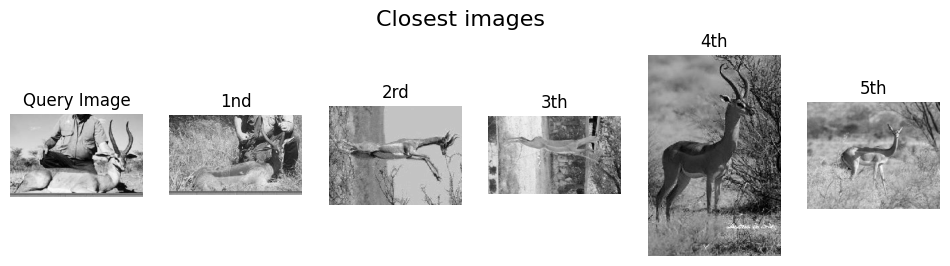

In [8]:
subresults = results[:7]

titles = ["Query Image", "1nd", "2rd", "3th", "4th", "5th"]
fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    axes[i].imshow(results.iloc[i]["im"], cmap="gray")
    axes[i].set_title(titles[i])
    axes[i].axis('off')
fig.suptitle('Closest images', fontsize=16)

# plt.imshow(results.iloc[18]["im"], cmap="gray", vmin=0, vmax=255)

In [9]:
# # clusters length
# '''
#     Filler code for testing
# '''
# images = os.listdir("caltech-101/101_ObjectCategories/hawksbill/")
# train, test = train_test_split(images, test_size=0.5, random_state=42)
# examples = [cv2.imread(os.path.join("caltech-101/101_ObjectCategories/hawksbill/", file)) for file in train]
# features = extract_features(examples)
# clusters = cluster_features(features, k=1000)

# #plot histograms
# plt.subplot(1, 2, 1)
# plt.bar(np.arange(0, len(clusters)), results.iloc[0]["hist"])
# plt.subplot(1, 2, 2)
# plt.bar(np.arange(0, len(clusters)), results.iloc[1]["hist"])

# Experiments

In [10]:
results_index = results.reset_index()

def experiment_train():
    mrr_train = 0
    top3_train = 0

    for i_merged, row_merged in merged_tables.iterrows():
        if row_merged["train-test"] == "train":
            for i_res, row_res in results_index.iterrows():
                #rank_i = 0
                if i_res == 0: continue                    
                if row_merged["category"] == row_res["category"]:
                    if i_res <= 3:
                        top3_train += 1
                    mrr_train += 1/i_res
                    break
    mrr_train /= len(results[results["train-test"] == "train"])
    percentage_top3_train = (top3_train / len(results[results["train-test"] == "train"])) * 100
    print(f"mrr for train: {mrr_train}, top3 percentage for train: {percentage_top3_train}")
    # print(mrr_train, percentage_top3_train)
experiment_train()

results_index = results.reset_index()
def experiment_test():
    mrr_test = 0
    top3_test = 0

    for i_merged, row_merged in merged_tables.iterrows():
        if row_merged["train-test"] == "test":
            for i_res, row_res in results_index.iterrows():
                #rank_i = 0
                if i_res == 0: continue
                if row_merged["category"] == row_res["category"]:
                    if i_res <= 3:
                        top3_test += 1
                    mrr_test += 1/i_res
                    break
    mrr_test /= len(results[results["train-test"] == "test"])
    percentage_top3_test = (top3_test / len(results[results["train-test"] == "test"])) * 100

    print(f"mrr for test: {mrr_test}, top3 percentage for test: {percentage_top3_test}")
    #print(mrr_test, percentage_top3_test)
experiment_test()

mrr for train: 0.18186517031054833, top3 percentage for train: 11.03896103896104
mrr for test: 0.1809990662931838, top3 percentage for test: 10.967741935483872


In [11]:
results_index

,level_0,index,file_name,category,train-test,im,hist
0,0,0,image_0032.jpg,gerenuk,test,"[[171, 171, 171, 171, 171, 171, 171, 171, 172,...","[0.0, 0.015576577631131516, 0.0077882888155657..."
1,18,18,image_0007.jpg,gerenuk,train,"[[47, 44, 56, 43, 34, 49, 48, 45, 62, 86, 95, ...","[0.032105941448691624, 0.0, 0.0, 0.01535056728..."
2,12,12,image_0008.jpg,gerenuk,test,"[[85, 36, 34, 105, 125, 136, 86, 105, 85, 143,...","[0.016052970724345812, 0.0, 0.0311531552622630..."
3,13,13,image_0009.jpg,gerenuk,test,"[[49, 66, 66, 152, 144, 139, 120, 106, 42, 47,...","[0.008026485362172906, 0.0, 0.0311531552622630..."
4,16,16,image_0022.jpg,gerenuk,test,"[[128, 129, 131, 133, 135, 136, 136, 136, 139,...","[0.032105941448691624, 0.007788288815565758, 0..."
...,...,...,...,...,...,...,...
304,10,10,image_0020.jpg,gerenuk,train,"[[147, 167, 134, 137, 158, 168, 126, 125, 117,...","[0.016052970724345812, 0.015576577631131516, 0..."
305,25,25,image_0001.jpg,gerenuk,train,"[[121, 109, 97, 92, 93, 94, 93, 93, 99, 87, 70...","[0.016052970724345812, 0.023364866446697274, 0..."
306,32,32,image_0003.jpg,gerenuk,test,"[[67, 67, 61, 57, 63, 76, 83, 81, 70, 68, 57, ...","[0.032105941448691624, 0.07009459934009181, 0...."
307,216,40,image_0003.jpg,ant,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.07358249321306029, 0.03483653361730514, 0.0..."
